# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

# Read files

In [3]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()

X_val = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
X_val = X_val.reset_index(drop=True)
y_val = X_val.ctx0.copy()

X_test = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
X_test = X_test.reset_index(drop=True)
y_test = X_test.ctx0.copy()


CPU times: user 39.5 s, sys: 3.2 s, total: 42.7 s
Wall time: 42.7 s


In [4]:
cat_y_train = ((y_train.copy()*100)/5).round().astype(int)
cat_y_val = ((y_val.copy()*100)/5).round().astype(int)
cat_y_test = ((y_test.copy()*100)/5).round().astype(int)

# View

In [5]:
years = X_train.year.unique().tolist()
years

[2019, 2020, 2021, 2022]

In [6]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
# nuniques = get_columns_nunique(data[config_year.year])
    
uniques = get_columns_unique(X_train)

# Visualizacion

# station_id

In [8]:
var = 'station_id'

<Axes: >

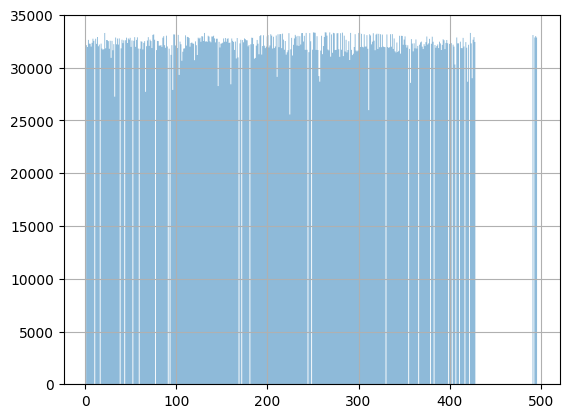

In [9]:
X_train[var].hist(histtype='stepfilled', alpha=.5, bins=X_train[var].max()+1)

In [10]:
%%time

print(stats.describe(X_train[var]))
X_train[var].describe()

DescribeResult(nobs=13143819, minmax=(1, 496), mean=216.29649016012775, variance=15337.986738784102, skewness=0.04362698681449548, kurtosis=-1.069680808278026)
CPU times: user 541 ms, sys: 0 ns, total: 541 ms
Wall time: 539 ms


count    1.314382e+07
mean     2.162965e+02
std      1.238466e+02
min      1.000000e+00
25%      1.120000e+02
50%      2.160000e+02
75%      3.190000e+02
max      4.960000e+02
Name: station_id, dtype: float64

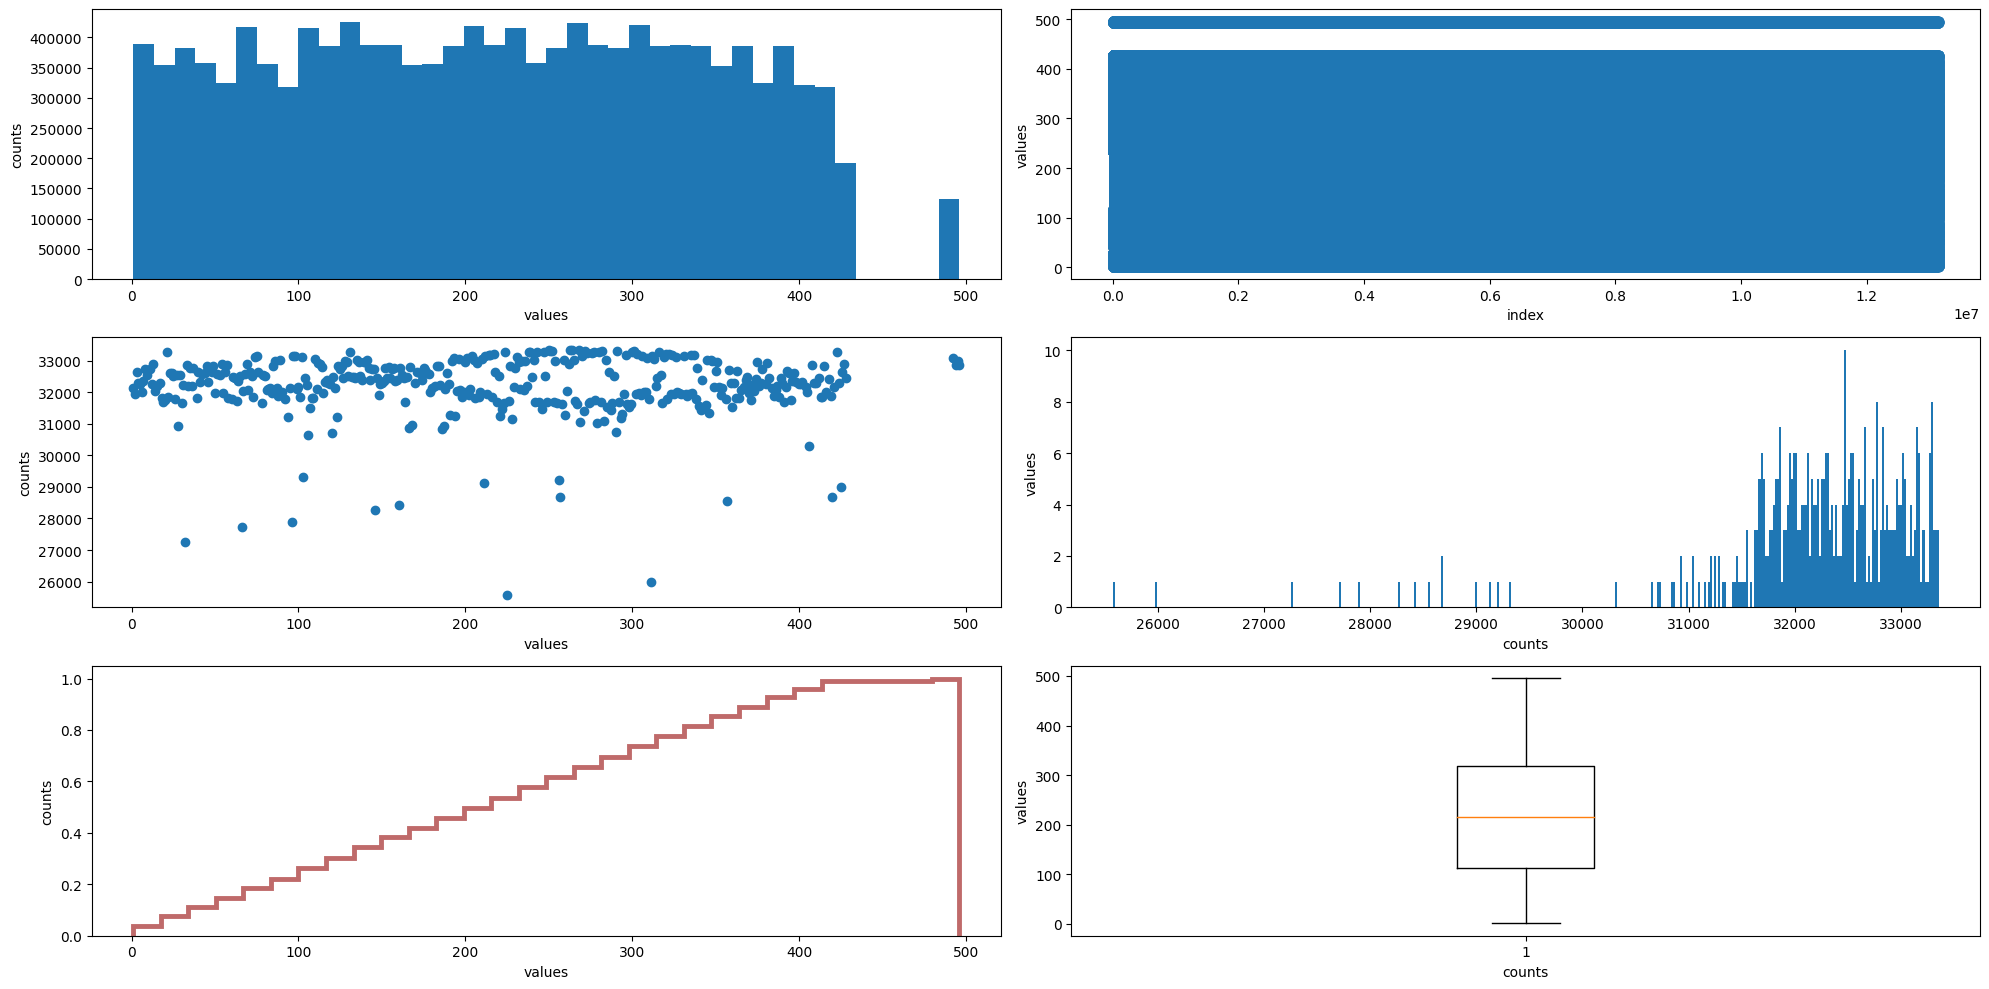

CPU times: user 18.1 s, sys: 187 ms, total: 18.3 s
Wall time: 18 s


In [11]:
%%time

show_counts(X_train[var])